# Imports

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

warnings.filterwarnings("ignore")


# Configuration & Reproducibility

In [2]:
SEED = 42
BASE_PATH = "/kaggle/input/csiro-biomass"
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Load & Pivot Dataset

In [3]:
df = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))

df = df.pivot_table(
    index="image_path",
    columns="target_name",
    values="target"
).reset_index()

df.fillna(0, inplace=True)

TARGET_COLUMNS = [
    'Dry_Green_g',
    'Dry_Dead_g',
    'Dry_Clover_g',
    'GDM_g',
    'Dry_Total_g'
]

print("Dataset shape:", df.shape)


Dataset shape: (357, 6)


# Train / Validation Split & Target Scaling

In [4]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    shuffle=True
)

scaler = StandardScaler()
scaler.fit(train_df[TARGET_COLUMNS].values)


StandardScaler()

# Dataset Class  

In [5]:
class BiomassDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, scaler=None):
        self.df = df.copy()
        self.df["image_path"] = self.df["image_path"].apply(os.path.basename)
        self.samples = list(self.df.itertuples(index=False))
        self.image_dir = image_dir
        self.transform = transform
        self.scaler = scaler

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples[idx]
        img_path = os.path.join(self.image_dir, row.image_path)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        target = np.array(
            [getattr(row, t) for t in TARGET_COLUMNS],
            dtype=np.float32
        )

        if self.scaler:
            target = self.scaler.transform(target.reshape(1, -1))[0]

        return image, torch.tensor(target)


# DataLoaders

In [6]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = BiomassDataset(
    train_df,
    os.path.join(BASE_PATH, "train"),
    transform,
    scaler
)

val_dataset = BiomassDataset(
    val_df,
    os.path.join(BASE_PATH, "train"),
    transform,
    scaler
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)


# Weighted Loss  

In [7]:
TARGET_WEIGHTS = torch.tensor(
    [0.1, 0.1, 0.1, 0.2, 0.5],
    device=DEVICE
)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.register_buffer("weights", weights)

    def forward(self, preds, targets):
        return ((preds - targets) ** 2 * self.weights).mean()

criterion = WeightedMSELoss(TARGET_WEIGHTS)


# Weighted R² Metric

In [8]:
def weighted_r2_score(y_true, y_pred, weights):
    mean_y = y_true.mean(0, keepdim=True)
    ss_res = ((y_true - y_pred) ** 2).sum(0)
    ss_tot = ((y_true - mean_y) ** 2).sum(0)
    return (1 - (weights * ss_res).sum() /
            ((weights * ss_tot).sum() + 1e-8)).item()


# CNN with Variable Kernel Size

In [9]:
class CNNWithKernelSize(nn.Module):
    def __init__(self, kernel_size=3, num_filters=256, num_blocks=3, num_outputs=5):
        super().__init__()

        layers = []
        in_channels = 3
        padding = kernel_size // 2

        for _ in range(num_blocks):
            layers.append(
                nn.Conv2d(
                    in_channels,
                    num_filters,
                    kernel_size=kernel_size,
                    padding=padding
                )
            )
            layers.append(nn.BatchNorm2d(num_filters))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(2))
            in_channels = num_filters

        layers.append(nn.AdaptiveAvgPool2d(1))

        self.features = nn.Sequential(*layers)
        self.regressor = nn.Linear(num_filters, num_outputs)

    def forward(self, x):
        x = self.features(x)
        return self.regressor(x.flatten(1))


# One-Epoch Train / Eval Function

In [10]:
def run_epoch(model, loader, optimizer=None):
    training = optimizer is not None
    model.train() if training else model.eval()

    total_loss, total_r2, n = 0.0, 0.0, 0

    with torch.set_grad_enabled(training):
        for images, targets in loader:
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)

            preds = model(images)
            loss = criterion(preds, targets)

            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            bsz = images.size(0)
            total_loss += loss.item() * bsz
            total_r2 += weighted_r2_score(
                targets, preds, TARGET_WEIGHTS
            ) * bsz
            n += bsz

    return total_loss / n, total_r2 / n


# Kernel Size Experiment [3, 5, 7]

In [11]:
kernel_options = [3, 5, 7]
results = {}

for k in kernel_options:
    print(f"\n==============================")
    print(f" Training CNN with kernel {k}x{k}")
    print(f"==============================")

    model = CNNWithKernelSize(
        kernel_size=k,
        num_filters=256,
        num_blocks=3,
        num_outputs=len(TARGET_COLUMNS)
    ).to(DEVICE)

    optimizer = optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

    train_losses, val_losses = [], []
    train_r2s, val_r2s = [], []
    best_val_r2 = -1e9

    # -------- Training epochs --------
    for epoch in range(NUM_EPOCHS):
        train_loss, train_r2 = run_epoch(
            model, train_loader, optimizer
        )
        val_loss, val_r2 = run_epoch(
            model, val_loader
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_r2s.append(train_r2)
        val_r2s.append(val_r2)

        best_val_r2 = max(best_val_r2, val_r2)

        print(
            f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"Train R²: {train_r2:.4f} | "
            f"Val R²: {val_r2:.4f}"
        )

    # -------- Store averaged metrics --------
    results[k] = {
        "best_val_r2": best_val_r2,
        "avg_train_loss": float(np.mean(train_losses)),
        "avg_val_loss": float(np.mean(val_losses)),
        "avg_train_r2": float(np.mean(train_r2s)),
        "avg_val_r2": float(np.mean(val_r2s)),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_r2s": train_r2s,
        "val_r2s": val_r2s
    }



 Training CNN with kernel 3x3
Epoch [1/20] | Train Loss: 0.2101 | Val Loss: 0.4448 | Train R²: -0.1831 | Val R²: -2.8216
Epoch [2/20] | Train Loss: 0.1656 | Val Loss: 0.1320 | Train R²: 0.0664 | Val R²: -0.0146
Epoch [3/20] | Train Loss: 0.1607 | Val Loss: 0.1238 | Train R²: 0.1576 | Val R²: 0.0411
Epoch [4/20] | Train Loss: 0.1579 | Val Loss: 0.1390 | Train R²: 0.1791 | Val R²: -0.1129
Epoch [5/20] | Train Loss: 0.1513 | Val Loss: 0.1151 | Train R²: 0.1808 | Val R²: 0.1225
Epoch [6/20] | Train Loss: 0.1531 | Val Loss: 0.1187 | Train R²: 0.0082 | Val R²: 0.0704
Epoch [7/20] | Train Loss: 0.1486 | Val Loss: 0.1054 | Train R²: 0.2041 | Val R²: 0.2345
Epoch [8/20] | Train Loss: 0.1483 | Val Loss: 0.1077 | Train R²: 0.1555 | Val R²: 0.1686
Epoch [9/20] | Train Loss: 0.1477 | Val Loss: 0.1173 | Train R²: 0.2101 | Val R²: 0.0803
Epoch [10/20] | Train Loss: 0.1419 | Val Loss: 0.1167 | Train R²: 0.1847 | Val R²: 0.0706
Epoch [11/20] | Train Loss: 0.1472 | Val Loss: 0.1306 | Train R²: 0.2255 |

# Summary Table

In [12]:
summary_df = pd.DataFrame([
    {
        "Kernel": f"{k}x{k}",
        "Avg Train Loss": results[k]["avg_train_loss"],
        "Avg Val Loss": results[k]["avg_val_loss"],
        "Avg Train R2": results[k]["avg_train_r2"],
        "Avg Val R2": results[k]["avg_val_r2"],
        "Best Val R2": results[k]["best_val_r2"]
    }
    for k in kernel_options
]).sort_values("Avg Val R2", ascending=False)

display(summary_df)


,Kernel,Avg Train Loss,Avg Val Loss,Avg Train R2,Avg Val R2,Best Val R2
1,5x5,0.155397,0.132328,0.13486,-0.025459,0.209893
2,7x7,0.155242,0.137965,0.14376,-0.085953,0.173202
0,3x3,0.147953,0.140283,0.17938,-0.109971,0.238753


# Plot Validation R²

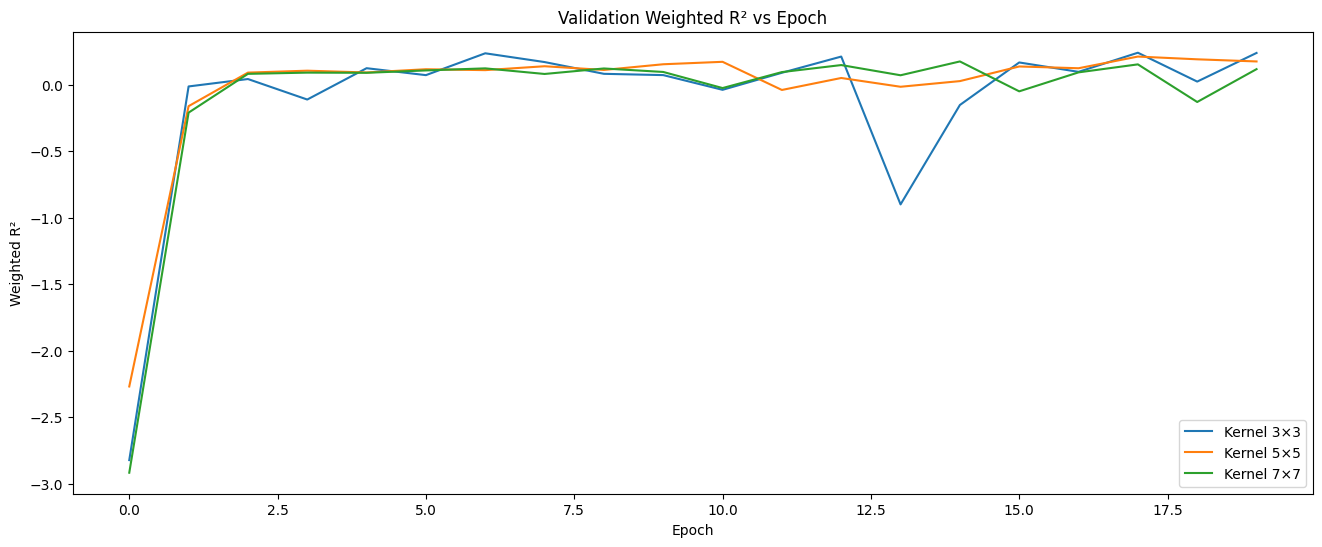

In [13]:
plt.figure(figsize=(16, 6))
for k in kernel_options:
    plt.plot(results[k]["val_r2s"], label=f"Kernel {k}×{k}")
plt.title("Validation Weighted R² vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Weighted R²")
plt.legend()
plt.show()


# Plot Validation Loss

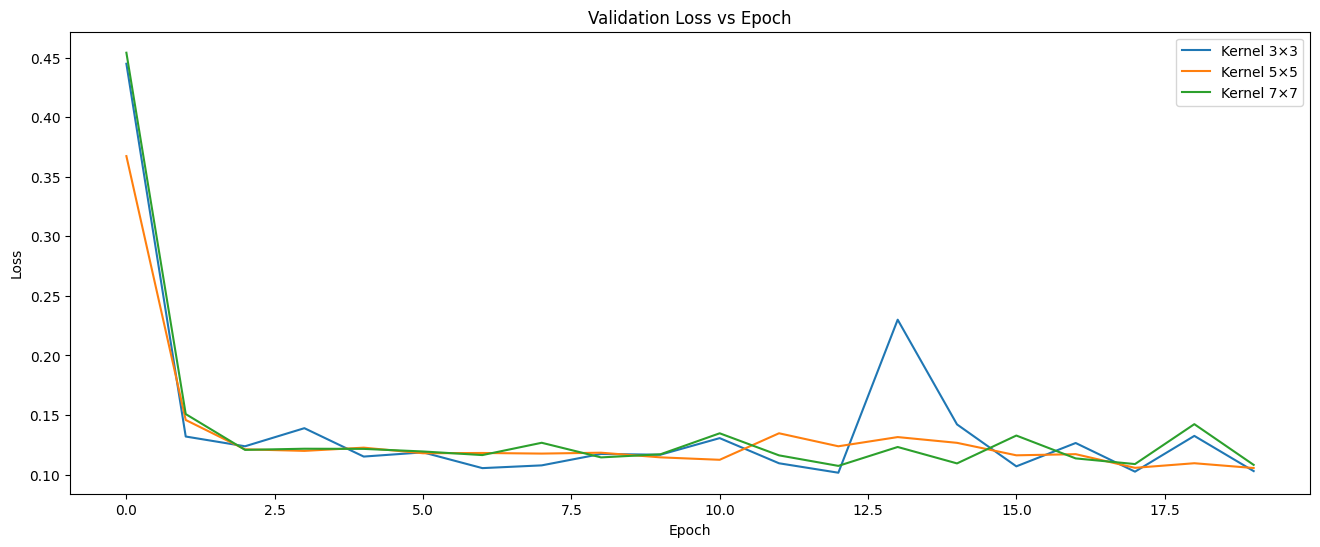

In [14]:
plt.figure(figsize=(16, 6))
for k in kernel_options:
    plt.plot(results[k]["val_losses"], label=f"Kernel {k}×{k}")
plt.title("Validation Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
